# 4. Example: 4DVar Backprop DA using Reservoir Computing ML Model

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
# from rc import RCModel
from IPython.lib.deepreload import reload
import pickle

In [2]:
np_rng = np.random.default_rng(seed=50)

## A. Create Nature Run

In [3]:
train_size = 20000 #100000
transient_size = 1000
test_size = 2000

In [4]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [5]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [6]:
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

## B. Generate Observations

In [7]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every 5th timestep
    random_location_count = 6,
    error_bias = 0.0, 
    error_sd = 0.5, 
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_l96 = obs_l96.observe()

## C. Define and train model

In [8]:
forecast_model = dab.model.RCModel(
    system_dim=6, 
    reservoir_dim=1600, 
    input_dim=6, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.07,
    spectral_radius = 0.1, 
    leak_rate=0.7,
    log_beta=-18.41)

In [9]:
forecast_model.weights_init()
forecast_model.train(nr_train)

# # Create a pickle file for saving weights
# picklefile = open('rcmodel_weights.pkl', 'wb')
# pickle.dump(forecast_model, picklefile)
# picklefile.close()

[[-0.01341213  0.05928678  0.02180245 -0.03691021  0.05087034 -0.00950436]
 [ 0.06629697  0.0535328  -0.00013336  0.02459833 -0.05761087 -0.0334143 ]
 [-0.01991044  0.01044831  0.00343808 -0.01381121  0.05664408 -0.00315729]
 ...
 [ 0.05472814 -0.02565975 -0.0192435   0.01620979  0.03702567 -0.05155982]
 [ 0.02405367  0.04201259  0.06247467 -0.06033704  0.06706107 -0.00638414]
 [-0.02170925  0.0004002   0.03496673  0.04101068 -0.01924207  0.00736085]]


In [11]:
# # Read the pickle file
# picklefile = open('rcmodel_weights', 'rb')
# forecast_model = pickle.load(picklefile)
# picklefile.close()

## D. Set up and run DA Cycler

In [16]:
obs_total_size = 18
sigma_obs=0.1
sigma_bg = 0.05

H = forecast_model.Wout
R = sigma_obs* np.identity(obs_total_size)
B = sigma_bg*np.identity(forecast_model.reservoir_dim)


In [17]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_transient.values
        + np.random.normal(size = (1000, nr_transient.system_dim), scale=0.05))[-1], nr_transient.values[-1])

In [18]:
num_epochs_per_cycle=20

In [19]:
dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=nature_run.delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=1e-7,
    num_epochs=num_epochs_per_cycle,
    model_obj=forecast_model,
    obs_window_indices=[0,5,10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )


Run the cycler

In [20]:
%%time

# Needs to be at least 1 otherwise unequal number of obs per cycle
cur_tstep = 0

r0_sv = dab.vector.StateVector(
    values=r0_original,
    store_as_jax=True)

# Run cycler for 1500 timesteps
out_statevec = dc.cycle(
    input_state = r0_sv,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    analysis_window=0.1,
    timesteps=198,
    obs_error_sd=sigma_obs,
    analysis_time_in_window=0.05)

CPU times: user 1min 39s, sys: 3.12 s, total: 1min 42s
Wall time: 1min 31s


In [21]:
analyses_stacked = forecast_model.readout(out_statevec.values)

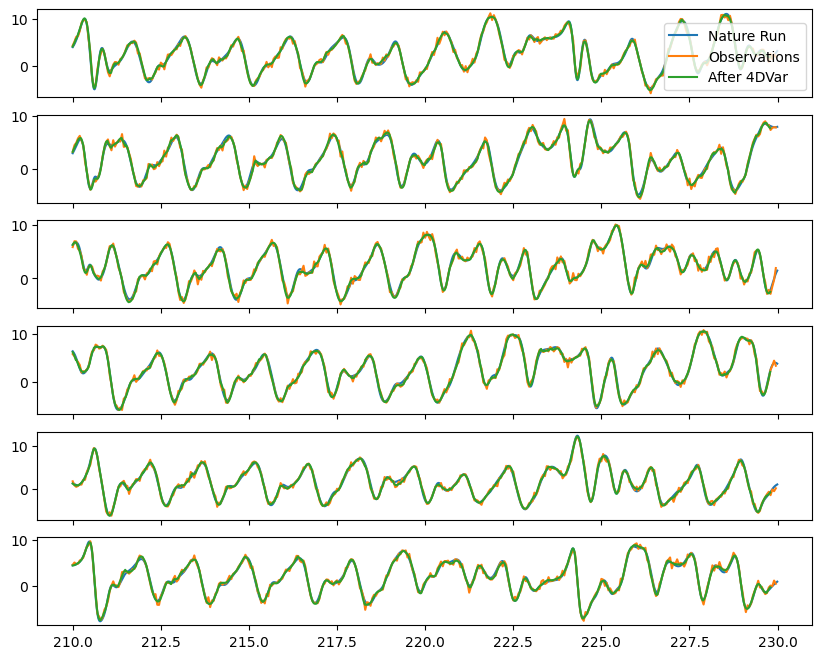

In [22]:
# Plot them all
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:, j], label='Nature Run')
    ax.plot(obs_vec_l96.times, obs_vec_l96.values[:, j], label='Observations')
    ax.plot(nr_test.times[:analyses_stacked.shape[0]], analyses_stacked[:, j], label='After 4DVar')

    if j ==0:
        ax.legend()